# Exploring the Examon database


In [1]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

from examon.examon import Examon

from itables import show
import itables.options as opt
opt.maxBytes = 0


### Examon setup

In [2]:
KAIROSDB_SERVER = 'examon.cineca.it'
KAIROSDB_PORT = '3000'
USER = ''
PWD = ''

ex = Examon(KAIROSDB_SERVER, port=KAIROSDB_PORT, user=USER, password=PWD, verbose=False, proxy=True)

### Metric list
To start with Examon, it is recommended that you first get a list of the sensors contained in the database. The initial object (ExamonQL) instantiation will do a full db scan checking for all the metrics tags. This will happen only the first time since the client uses caches where possible to save the database bandwith.

In [3]:
from examon.examon import ExamonQL

sq = ExamonQL(ex)

display(pd.DataFrame(sq.metric_list))


name
0                  0_0
1                  12V
2     1U_Stg_HDD0_Pres
3     1U_Stg_HDD1_Pres
4     1U_Stg_HDD2_Pres
...                ...
1934         vm_pgpgin
1935        vm_pgpgout
1936          vm_vmeff
1937          wind_deg
1938        wind_speed

[1939 rows x 1 columns]

### Tag Keys
Each metric in the database comes with a set of tags (key;value) useful for filtering during queries. 
It is possible to obtain from the database all the possible tags (keys) associated to a specific metric.


In [4]:
df = sq.DESCRIBE() \
    .execute()

display(df)

name                                           tag keys
0                  0_0  [chnl, cluster, node, org, plugin, rack, slot,...
1                  12V  [chnl, cluster, health, node, org, plugin, typ...
2     1U_Stg_HDD2_Pres   [chnl, cluster, health, node, org, plugin, type]
3     1U_Stg_HDD5_Pres   [chnl, cluster, health, node, org, plugin, type]
4     1U_Stg_HDD4_Pres   [chnl, cluster, health, node, org, plugin, type]
...                ...                                                ...
1933      rx_drops_ib0  [chnl, cluster, gcluster, group, node, org, pl...
1934         swap_free  [chnl, cluster, gcluster, group, node, org, pl...
1935        swap_total  [chnl, cluster, gcluster, group, node, org, pl...
1936             state  [chnl, cluster, description, host_group, nagio...
1937     plugin_output  [chnl, cluster, description, host_group, nagio...

[1938 rows x 2 columns]

The database contains this number of valid metric names:

In [5]:
df.shape[0]

1938

To get an entry from the table:

In [6]:
df[df.name == 'Ambient_Temp']['tag keys'].values[0]

['chnl', 'cluster', 'health', 'node', 'org', 'part', 'plugin', 'type', 'units']

### Tag values
It is possible to obtain all the possible values of all the tag keys of a given metric: 

In [7]:
opt.classes = ["display", "nowrap"]

df = sq.DESCRIBE(metric='CPU_Utilization') \
    .execute()

display(df)

name  tag key                                         tag values
0  CPU_Utilization     chnl                                             [data]
1  CPU_Utilization  cluster                                 [galileo, marconi]
2  CPU_Utilization   health                                               [ok]
3  CPU_Utilization     node  [node001, node002, node003, node004, node005, ...
4  CPU_Utilization      org                                           [cineca]
5  CPU_Utilization     part                                     [knl, skylake]
6  CPU_Utilization   plugin                          [confluent_pub, ipmi_pub]
7  CPU_Utilization     type                                            [Other]

### All the possible values of a given tag key
In this example we will search all the plugin names currently available in the Examon database.

In [8]:
df = sq.DESCRIBE(tag_key = 'plugin') \
    .execute()

display(df)

tag values
0                     ipmi_pub
1                confluent_pub
2                   vertiv_pub
3                schneider_pub
4                      pmu_pub
5                   logics_pub
6   predictive_maintenance_pub
7                  ganglia_pub
8                   nvidia_pub
9                  weather_pub
10                   slurm_pub
11                  nagios_pub

### Metrics having a given tag value
Assume that we need to know the list of the metrics having a given tag (key, value).
In this example, we get the list of all metrics inserted into the db by the 'confluent_pub' examon plugin.

In [9]:
df = sq.DESCRIBE(tag_key = 'plugin', tag_value='confluent_pub') \
    .execute()

display(df)

name
0                 12V
1    1U_Stg_HDD0_Pres
2    1U_Stg_HDD1_Pres
3    1U_Stg_HDD2_Pres
4    1U_Stg_HDD3_Pres
..                ...
379             Vcpu1
380             Vcpu2
381     Voltage_Fault
382     XCC_Corrupted
383    XCC_SWitchover

[384 rows x 1 columns]

#### Metrics valid only for Marconi skaylake nodes
Some metrics are valid (exist) only for a subset of the monitored resources. In this example we will search for the metrics collected by the 'confluent_pub' plugin and for the 'marconi' cluster and for only the 'skylake' partition. The 'JOIN' command let you 'intersect' ('inner' join) the results of each DESCRIBE command.

In [10]:
df = sq.DESCRIBE(tag_key = 'plugin', tag_value='confluent_pub') \
    .DESCRIBE(tag_key = 'cluster', tag_value='marconi') \
    .DESCRIBE(tag_key = 'part', tag_value='skylake') \
    .JOIN(how='inner') \
    .execute()

display(df)

name
0            All_CPUs
1           All_DIMMs
2       All_PCI_Error
3        Ambient_Temp
4             Aux_Log
..                ...
140   Sys_Utilization
141   System_Air_Flow
142  TPM_TCM_Init_Err
143     XCC_Corrupted
144    XCC_SWitchover

[145 rows x 1 columns]

#### Metrics collected by the 'nagios_pub' plugin

In [11]:
df = sq.DESCRIBE(tag_key = 'plugin', tag_value='nagios_pub') \
    .execute()

display(df)

name
0  hostscheduleddowtimecomments
1                 plugin_output
2                         state

Check the tags available for the 'plugin_output' metric

In [12]:
df = sq.DESCRIBE(metric='plugin_output') \
    .execute()

display(df)

name        tag key  \
0   plugin_output           chnl   
1   plugin_output        cluster   
2   plugin_output    description   
3   plugin_output     host_group   
4   plugin_output  nagiosdrained   
5   plugin_output           node   
6   plugin_output            org   
7   plugin_output         plugin   
8   plugin_output           rack   
9   plugin_output           slot   
10  plugin_output          state   
11  plugin_output     state_type   

                                           tag values  
0                                              [data]  
1                      [galileo, marconi, marconi100]  
2   [EFGW_cluster::status::availability, EFGW_clus...  
3   [compute, compute,cincompute, containers, cumu...  
4                                              [0, 1]  
5   [ems02, ethcore01-mgt, ethcore02-mgt, gss03, g...  
6                                            [cineca]  
7                                        [nagios_pub]  
8   [202, 205, 206, 207, 208, 209, 210, 211, 212, ...  
9   [01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 1...  
10                                       [0, 1, 2, 3]  
11                                             [0, 1]

The 'description' tag may have some hints about the services monitored by this plugin. Lets check it:

In [13]:
df[df['tag key'] == 'description']['tag values'].values[0]


['EFGW_cluster::status::availability',
 'EFGW_cluster::status::criticality',
 'EFGW_cluster::status::internal',
 'GALILEO_cluster::status::availability',
 'GALILEO_cluster::status::criticality',
 'GALILEO_cluster::status::internal',
 'afs::blocked_conn::status',
 'afs::bosserver::status',
 'afs::ptserver::status',
 'afs::space::status',
 'afs::vlserver::status',
 'alive::ping',
 'backup::afs::status',
 'backup::eufus_gw::status',
 'backup::local::status',
 'backup::shared::status',
 'batchs::JobsH',
 'batchs::client',
 'batchs::client::serverrespond',
 'batchs::client::state',
 'batchs::manager',
 'batchs::manager::state',
 'bmc::events',
 'cluster::status::availability',
 'cluster::status::criticality',
 'cluster::status::internal',
 'container::check::health',
 'container::check::internal',
 'container::check::mounts',
 'core::total',
 'dev::ipmi::events',
 'dev::raid::status',
 'dev::swc::bntfru',
 'dev::swc::bnthealth',
 'dev::swc::bnttemp',
 'dev::swc::confcheck',
 'dev::swc::conf

Lets see if there are services in a 'critical' state (2) and which node affect:

In [14]:
# itables options
opt.classes = ["display", "wrap"]

data = sq.SELECT('node','cluster','description','state') \
    .FROM('plugin_output') \
    .WHERE(plugin='nagios_pub', state='2') \
    .TSTART(30, 'minutes') \
    .execute()

display(data.df_table.head(10))

timestamp  \
0 2021-08-31 19:45:00.109000+02:00   
1 2021-08-31 20:00:00.099000+02:00   
2 2021-08-31 19:45:00.109000+02:00   
3 2021-08-31 20:00:00.099000+02:00   
4 2021-08-31 19:45:00.109000+02:00   
5 2021-08-31 20:00:00.099000+02:00   
6 2021-08-31 19:45:00.109000+02:00   
7 2021-08-31 20:00:00.099000+02:00   
8 2021-08-31 19:45:00.109000+02:00   
9 2021-08-31 20:00:00.099000+02:00   

                                               value           name      node  \
0                   C(/gss/gss_work[umount]) W() O()  plugin_output   login03   
1                   C(/gss/gss_work[umount]) W() O()  plugin_output   login03   
2  C(rpcinfo=servok:callsok{/gss/gss_work[umount]...  plugin_output   login03   
3  C(rpcinfo=servok:callsok{/gss/gss_work[umount]...  plugin_output   login03   
4                            Definiti solo 54 utenti  plugin_output   login03   
5                            Definiti solo 54 utenti  plugin_output   login03   
6  C(bunch writes: False, bunch sends: True, Flow...  plugin_output  master01   
7  C(bunch writes: False, bunch sends: True, Flow...  plugin_output  master01   
8  C(bunch writes: False, bunch sends: True, Flow...  plugin_output  master02   
9  C(bunch writes: False, bunch sends: True, Flow...  plugin_output  master02   

      cluster                    description state  
0  marconi100           filesys::dres::mount     2  
1  marconi100           filesys::dres::mount     2  
2  marconi100               nfs::rpc::status     2  
3  marconi100               nfs::rpc::status     2  
4  marconi100              sys::sssd::events     2  
5  marconi100              sys::sssd::events     2  
6  marconi100  galera::status::ReplicaStatus     2  
7  marconi100  galera::status::ReplicaStatus     2  
8  marconi100  galera::status::ReplicaStatus     2  
9  marconi100  galera::status::ReplicaStatus     2

In [15]:
data.df_table.shape

(230, 7)

## Query Examples
### 1) Marconi Skylake Power Consumption 


In [16]:
data = sq.SELECT('cluster','part','node') \
    .FROM('Sys_Power') \
    .WHERE(cluster='marconi', part='skylake') \
    .TSTART(30, 'minutes') \
    .AGGRBY('avg', sampling_value=1, sampling_unit='minutes') \
    .execute()

display(data.df_table.head())

timestamp  value       name  cluster     part  \
0 2021-08-31 19:37:00.029000+02:00    120  Sys_Power  marconi  skylake   
1 2021-08-31 19:38:00.029000+02:00    120  Sys_Power  marconi  skylake   
2 2021-08-31 19:39:00.028000+02:00    120  Sys_Power  marconi  skylake   
3 2021-08-31 19:40:00.027000+02:00    120  Sys_Power  marconi  skylake   
4 2021-08-31 19:41:00.031000+02:00    120  Sys_Power  marconi  skylake   

         node  
0  r129c01s01  
1  r129c01s01  
2  r129c01s01  
3  r129c01s01  
4  r129c01s01

In [17]:
data.df_table.shape

(70548, 6)

Check the number of nodes ('node' tag):

In [18]:
display(data.df_table.nunique())

timestamp     132
value          38
name            1
cluster         1
part            1
node         3186
dtype: int64

#### Time Series Format
Reshape the 'df_table' to a time series table: first column (index) = timestamp, remaining columns = nodes power vectors. 

In [19]:
data.to_series(flat_index=True, interp='time', dropna=True, columns=['node'])

display(data.df_ts.head())

node                              r129c01s01  r129c01s02  r129c01s03  \
timestamp                                                              
2021-08-31 19:40:00.059000+02:00       120.0       120.0       120.0   
2021-08-31 19:41:00.022000+02:00       120.0       120.0       120.0   
2021-08-31 19:41:00.024000+02:00       120.0       120.0       120.0   
2021-08-31 19:41:00.029000+02:00       120.0       120.0       120.0   
2021-08-31 19:41:00.031000+02:00       120.0       120.0       120.0   

node                              r129c01s04  r129c02s01  r129c02s02  \
timestamp                                                              
2021-08-31 19:40:00.059000+02:00       120.0  149.984001       110.0   
2021-08-31 19:41:00.022000+02:00       120.0  120.004500       110.0   
2021-08-31 19:41:00.024000+02:00       120.0  120.003500       110.0   
2021-08-31 19:41:00.029000+02:00       120.0  120.001000       110.0   
2021-08-31 19:41:00.031000+02:00       120.0  120.000000       110.0   

node                              r129c02s03  r129c02s04  r129c03s01  \
timestamp                                                              
2021-08-31 19:40:00.059000+02:00       280.0       280.0       280.0   
2021-08-31 19:41:00.022000+02:00       280.0       280.0       280.0   
2021-08-31 19:41:00.024000+02:00       280.0       280.0       280.0   
2021-08-31 19:41:00.029000+02:00       280.0       280.0       280.0   
2021-08-31 19:41:00.031000+02:00       280.0       280.0       280.0   

node                              r129c03s02  ...  r183c14s03  r183c14s04  \
timestamp                                     ...                           
2021-08-31 19:40:00.059000+02:00       290.0  ...       260.0       240.0   
2021-08-31 19:41:00.022000+02:00       290.0  ...       260.0       240.0   
2021-08-31 19:41:00.024000+02:00       290.0  ...       260.0       240.0   
2021-08-31 19:41:00.029000+02:00       290.0  ...       260.0       240.0   
2021-08-31 19:41:00.031000+02:00       290.0  ...       260.0       240.0   

node                              r183c15s01  r183c15s02  r183c15s03  \
timestamp                                                              
2021-08-31 19:40:00.059000+02:00       260.0       260.0       250.0   
2021-08-31 19:41:00.022000+02:00       260.0       260.0       250.0   
2021-08-31 19:41:00.024000+02:00       260.0       260.0       250.0   
2021-08-31 19:41:00.029000+02:00       260.0       260.0       250.0   
2021-08-31 19:41:00.031000+02:00       260.0       260.0       250.0   

node                              r183c15s04  r183c16s01  r183c16s02  \
timestamp                                                              
2021-08-31 19:40:00.059000+02:00         0.0       250.0       250.0   
2021-08-31 19:41:00.022000+02:00         0.0       250.0       250.0   
2021-08-31 19:41:00.024000+02:00         0.0       250.0       250.0   
2021-08-31 19:41:00.029000+02:00         0.0       250.0       250.0   
2021-08-31 19:41:00.031000+02:00         0.0       250.0       250.0   

node                              r183c16s03  r183c16s04  
timestamp                                                 
2021-08-31 19:40:00.059000+02:00       230.0       230.0  
2021-08-31 19:41:00.022000+02:00       230.0       230.0  
2021-08-31 19:41:00.024000+02:00       230.0       230.0  
2021-08-31 19:41:00.029000+02:00       230.0       230.0  
2021-08-31 19:41:00.031000+02:00       230.0       230.0  

[5 rows x 3186 columns]

### Skylake partition total power consuption 
Total average power in the previous 30 minutes

In [20]:
data.df_ts.mean().sum()

836732.253862509

### 2) Looking for failures

First look for metrics with critical status. Use the intersection: search metrics having...

In [21]:
df = sq.DESCRIBE(tag_key = 'plugin', tag_value='confluent_pub') \
    .DESCRIBE(tag_key = 'health', tag_value='critical') \
    .DESCRIBE(tag_key = 'part', tag_value='skylake') \
    .JOIN() \
    .execute()

display(df)

name
0          All_DIMMs
1      All_PCI_Error
2       Ambient_Temp
3       CMOS_Battery
4          CPU_1_DTS
5     CPU_1_Overtemp
6         CPU_1_PECI
7   CPU_1_QPILinkErr
8          CPU_2_DTS
9     CPU_2_Overtemp
10        CPU_2_PECI
11  CPU_2_QPILinkErr
12            DIMM_1
13          DIMM_10_
14           DIMM_11
15          DIMM_11_
16           DIMM_14
17          DIMM_14_
18          DIMM_15_
19           DIMM_16
20          DIMM_16_
21           DIMM_1_
22           DIMM_2_
23            DIMM_3
24           DIMM_3_
25            DIMM_6
26           DIMM_6_
27           DIMM_7_
28           DIMM_8_
29           DIMM_9_
30           DRIVE_0
31           DRIVE_1
32           DRIVE_2
33           DRIVE_3
34           DRIVE_4
35           DRIVE_5
36        Fan1A_Tach
37        Fan2A_Tach
38        Fan2B_Tach
39        Fan3A_Tach
40        Fan3B_Tach
41        Fan4A_Tach
42        Fan4B_Tach
43        Fan5A_Tach
44        Fan5B_Tach
45        Host_Power
46        M2_Drive_1
47          ME_Error
48         NMI_State
49       One_of_PCIs
50            PCIe_1
51            PCIe_5
52      PSU1_Failure
53   PSU1_IN_Failure
54      PSU2_Failure
55   PSU2_IN_Failure
56    Power_Supply_1
57    Power_Supply_2
58  SysBrd_Vol_Fault

For example, lets check for **CPU_1_Overtemp** metric over the last year to find the affected nodes and the time period

In [22]:
# itables options
opt.classes = ["display", "nowrap"]

# show the tags to filter
df = sq.DESCRIBE(metric='CPU_1_Overtemp') \
    .execute()

display(df)

name  tag key                                         tag values
0  CPU_1_Overtemp     chnl                                             [data]
1  CPU_1_Overtemp  cluster                                 [galileo, marconi]
2  CPU_1_Overtemp   health                    [critical, failed, ok, warning]
3  CPU_1_Overtemp     node  [r054c02s01, r054c02s02, r054c02s03, r054c02s0...
4  CPU_1_Overtemp      org                                           [cineca]
5  CPU_1_Overtemp     part                                     [knl, skylake]
6  CPU_1_Overtemp   plugin                                    [confluent_pub]
7  CPU_1_Overtemp     type                                      [Temperature]

In [23]:
# query
data = sq.SELECT('*') \
    .FROM('CPU_1_Overtemp') \
    .WHERE(part='skylake', health='critical') \
    .TSTART(1,'years') \
    .execute()

display(data.df_table.head())

timestamp     value            name  chnl  cluster  \
0 2021-03-10 15:42:00.032000+01:00  critical  CPU_1_Overtemp  data  marconi   
1 2021-03-10 15:43:00.028000+01:00  critical  CPU_1_Overtemp  data  marconi   
2 2021-03-10 15:44:00.122000+01:00  critical  CPU_1_Overtemp  data  marconi   
3 2021-03-10 15:45:00.031000+01:00  critical  CPU_1_Overtemp  data  marconi   
4 2021-03-10 15:46:00.028000+01:00  critical  CPU_1_Overtemp  data  marconi   

     health        node     org     part         plugin         type  
0  critical  r132c01s01  cineca  skylake  confluent_pub  Temperature  
1  critical  r132c01s01  cineca  skylake  confluent_pub  Temperature  
2  critical  r132c01s01  cineca  skylake  confluent_pub  Temperature  
3  critical  r132c01s01  cineca  skylake  confluent_pub  Temperature  
4  critical  r132c01s01  cineca  skylake  confluent_pub  Temperature

Show the first value of each node (when the anomaly appeared for the first time)

In [24]:
# itables options
opt.classes = ["display", "wrap"]

display(data \
        .df_table \
        .groupby('node') \
        .first() \
        .sort_values(by=['timestamp'],ascending=False) \
        .head())

timestamp     value            name  chnl  \
node                                                                          
r143c02s04 2021-08-02 15:24:00.012000+02:00  critical  CPU_1_Overtemp  data   
r175c05s04 2021-06-30 15:35:00.015000+02:00  critical  CPU_1_Overtemp  data   
r181c07s01 2021-06-16 17:08:00.026000+02:00  critical  CPU_1_Overtemp  data   
r143c04s03 2021-05-26 04:59:00.007000+02:00  critical  CPU_1_Overtemp  data   
r169c18s04 2021-04-21 05:25:00.058000+02:00  critical  CPU_1_Overtemp  data   

            cluster    health     org     part         plugin         type  
node                                                                        
r143c02s04  marconi  critical  cineca  skylake  confluent_pub  Temperature  
r175c05s04  marconi  critical  cineca  skylake  confluent_pub  Temperature  
r181c07s01  marconi  critical  cineca  skylake  confluent_pub  Temperature  
r143c04s03  marconi  critical  cineca  skylake  confluent_pub  Temperature  
r169c18s04  marconi  critical  cineca  skylake  confluent_pub  Temperature

Show the last value of each node (when the anomaly was removed/solved)

In [25]:
display(data \
        .df_table \
        .groupby('node') \
        .last() \
        .sort_values(by=['timestamp'],ascending=False) \
        .head())

timestamp     value            name  chnl  \
node                                                                          
r143c04s03 2021-08-31 17:07:00.033000+02:00  critical  CPU_1_Overtemp  data   
r139c12s02 2021-08-12 17:37:00.017000+02:00  critical  CPU_1_Overtemp  data   
r143c02s04 2021-08-02 15:24:00.012000+02:00  critical  CPU_1_Overtemp  data   
r171c09s01 2021-07-30 05:32:00.063000+02:00  critical  CPU_1_Overtemp  data   
r175c05s04 2021-06-30 15:47:00.028000+02:00  critical  CPU_1_Overtemp  data   

            cluster    health     org     part         plugin         type  
node                                                                        
r143c04s03  marconi  critical  cineca  skylake  confluent_pub  Temperature  
r139c12s02  marconi  critical  cineca  skylake  confluent_pub  Temperature  
r143c02s04  marconi  critical  cineca  skylake  confluent_pub  Temperature  
r171c09s01  marconi  critical  cineca  skylake  confluent_pub  Temperature  
r175c05s04  marconi  critical  cineca  skylake  confluent_pub  Temperature

For example, node 'r145c10s04' showed a crtical status for the CPU1 temperature starting from 2019-09-23 16:54 to 2019-09-26 04:27. Lets check it plotting that range plus 1 hour before and after:

<AxesSubplot:xlabel='timestamp'>

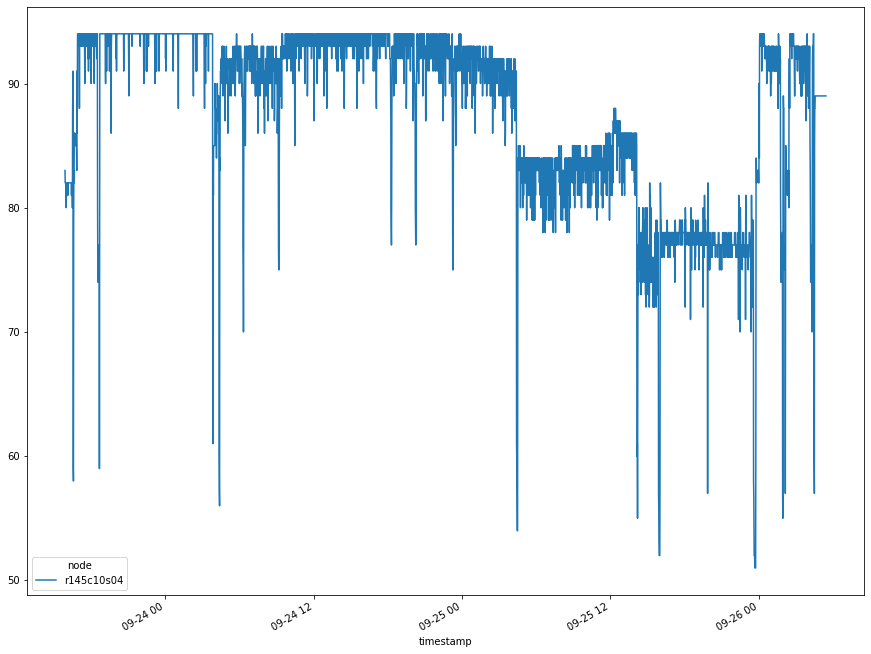

In [26]:
data = sq.SELECT('*') \
    .FROM('CPU_1_Temp') \
    .WHERE(node='r145c10s04') \
    .TSTART('23-09-2019 15:54:00') \
    .TSTOP('26-09-2019 05:27:00') \
    .execute()

data.to_series(flat_index=True, interp='time', dropna=True, columns=['node']).df_ts.plot(figsize=[15,12])

Where we can see values greater than 90 °C for the CPU1

## Job scheduler data
<div class="alert alert-warning">
<b>NOTE</b> This is an experimental feature and is subject to change in future versions.
</div>

Currently the job scheduler data is collected as per-job data in plain Cassandra tables. The available tables in the database are
* **job_info_galileo**: Galileo jobs data
* **job_info_marconi**: Marconi jobs data

This is a description of the data currently stored (where available) for each executed job:

| Table fields          | Description                                                                          |
|-----------------------|--------------------------------------------------------------------------------------|
| account               | charge to specified account                                                          |
| accrue_time           | time job is eligible for running                                                     |
| admin_comment         | administrator's arbitrary comment                                                    |
| alloc_node            | local node and system id making the resource allocation                              |
| alloc_sid             | local sid making resource alloc                                                      |
| array_job_id          | job_id of a job array or 0 if N/A                                                    |
| array_max_tasks       | Maximum number of running tasks                                                      |
| array_task_id         | task_id of a job array                                                               |
| array_task_str        | string expression of task IDs in this record                                         |
| assoc_id              | association id for job                                                               |
| batch_features        | features required for batch script's node                                            |
| batch_flag            | 1 if batch: queued job with script                                                   |
| batch_host            | name of host running batch script                                                    |
| billable_tres         | billable TRES cache. updated upon resize                                             |
| bitflags              | Various job flags                                                                    |
| boards_per_node       | boards per node required by job                                                      |
| burst_buffer          | burst buffer specifications                                                          |
| burst_buffer_state    | burst buffer state info                                                              |
| command               | command to be executed, built from submitted  job's argv and NULL for salloc command |
| comment               | arbitrary comment                                                                    |
| contiguous            | 1 if job requires contiguous nodes                                                   |
| core_spec             | specialized core count                                                               |
| cores_per_socket      | cores per socket required by job                                                     |
| cpu_freq_gov          | cpu frequency governor                                                               |
| cpu_freq_max          | Maximum cpu frequency                                                                |
| cpu_freq_min          | Minimum cpu frequency                                                                |
| cpus_alloc_layout     | map: list of cpu allocated per node                                                  |
| cpus_allocated        | map: number of cpu allocated per node                                                 |
| cpus_per_task         | number of processors required for each task                                          |
| cpus_per_tres         | semicolon delimited list of TRES=# values                                            |
| dependency            | synchronize job execution with other jobs                                            |
| derived_ec            | highest exit code of all job steps                                                   |
| eligible_time         | time job is eligible for running                                                     |
| end_time              | time of termination, actual or expected                                              |
| exc_nodes             | comma separated list of excluded nodes                                               |
| exit_code             | exit code for job (status from wait call)                                            |
| features              | comma separated list of required features                                            |
| group_id              | group job submitted as                                                               |
| job_id                | job ID                                                                               |
| job_state             | state of the job, see enum job_states                                                |
| last_sched_eval       | last time job was evaluated for scheduling                                           |
| licenses              | licenses required by the job                                                         |
| max_cpus              | maximum number of cpus usable by job                                                 |
| max_nodes             | maximum number of nodes usable by job                                                |
| mem_per_cpu           | boolean                                                                              |
| mem_per_node          | boolean                                                                              |
| mem_per_tres          | semicolon delimited list of TRES=# values                                            |
| min_memory_cpu        | minimum real memory required per allocated CPU                                       |
| min_memory_node       | minimum real memory required per node                                                |
| name                  | name of the job                                                                      |
| network               | network specification                                                                |
| nice                  | requested priority change                                                            |
| nodes                 | list of nodes allocated to job                                                       |
| ntasks_per_board      | number of tasks to invoke on each board                                              |
| ntasks_per_core       | number of tasks to invoke on each core                                               |
| ntasks_per_core_str   | number of tasks to invoke on each core  as string                                    |
| ntasks_per_node       | number of tasks to invoke on each node                                               |
| ntasks_per_socket     | number of tasks to invoke on each socket                                             |
| ntasks_per_socket_str | number of tasks to invoke on each socket as string                                   |
| num_cpus              | minimum number of cpus required by job                                               |
| num_nodes             | minimum number of nodes required by job                                              |
| partition             | name of assigned partition                                                           |
| pn_min_cpus           | minimum # CPUs per node, default=0                                                   |
| pn_min_memory         | minimum real memory per node, default=0                                              |
| pn_min_tmp_disk       | minimum tmp disk per node, default=0                                                 |
| power_flags           | power management flags,  see SLURM_POWER_FLAGS_                                      |
| pre_sus_time          | time job ran prior to last suspend                                                   |
| preempt_time          | preemption signal time                                                               |
| priority              | relative priority of the job, 0=held, 1=required nodes DOWN/DRAINED                  |
| profile               | Level of acct_gather_profile {all / none}                                            |
| qos                   | Quality of Service                                                                   |
| reboot                | node reboot requested before start                                                   |
| req_nodes             | comma separated list of required nodes                                               |
| req_switch            | Minimum number of switches                                                           |
| requeue               | enable or disable job requeue option                                                 |
| resize_time           | time of latest size change                                                           |
| restart_cnt           | count of job restarts                                                                |
| resv_name             | reservation name                                                                     |
| run_time              | job run time (seconds)                                                               |
| run_time_str          | job run time (seconds) as string                                                     |
| sched_nodes           | list of nodes scheduled to be used for job                                           |
| shared                | 1 if job can share nodes with other jobs                                             |
| show_flags            | conveys level of details requested                                                   |
| sockets_per_board     | sockets per board required by job                                                    |
| sockets_per_node      | sockets per node required by job                                                     |
| start_time            | time execution begins, actual or expected                                            |
| state_reason          | reason job still pending or failed, see slurm.h:enum job_state_reason                |
| std_err               | pathname of job's stderr file                                                        |
| std_in                | pathname of job's stdin file                                                         |
| std_out               | pathname of job's stdout file                                                        |
| submit_time           | time of job submission                                                               |
| suspend_time          | time job last suspended or resumed                                                   |
| system_comment        | slurmctld's arbitrary comment                                                        |
| threads_per_core      | threads per core required by job                                                     |
| time_limit            | maximum run time in minutes or INFINITE                                              |
| time_limit_str        | maximum run time in minutes or INFINITE as string                                    |
| time_min              | minimum run time in minutes or INFINITE                                              |
| tres_alloc_str        | tres used in the job as string                                                       |
| tres_bind             | Task to TRES binding directives                                                      |
| tres_freq             | TRES frequency directives                                                            |
| tres_per_job          | semicolon delimited list of TRES=# values                                            |
| tres_per_node         | semicolon delimited list of TRES=# values                                            |
| tres_per_socket       | semicolon delimited list of TRES=# values                                            |
| tres_per_task         | semicolon delimited list of TRES=# values                                            |
| tres_req_str          | tres reqeusted in the job as string                                                  |
| user_id               | user the job runs as                                                                 |
| wait4switch           | Maximum time to wait for minimum switches                                            |
| wckey                 | wckey for job                                                                        |
| work_dir              | pathname of working directory                                                        |

### Query examples
Queries can be executed as usual but paying attention to the following limitations:

* both TSTART and TSTOP statements must be specified
* the date currently is supported only in the string format 
* pushdown filters (executed on the datastore) are available only for a subset of table columns:
 * job_id
 * job_state
 * account
 * user_id 
 * node (keys of __cpus_alloc_layout__ table column)

In [27]:
# Ask for all galileo jobs executed between '28-09-2019 08:09:00' and '30-09-2019 08:09:00'

import json

# Setup 
sq.jc.JOB_TABLES.add('job_info_galileo')

data = sq.SELECT('*') \
    .FROM('job_info_galileo') \
    .TSTART('28-09-2019 08:09:00') \
    .TSTOP('30-09-2019 08:09:00') \
    .execute()  

df = pd.DataFrame(json.loads(data))
df.head()

job_id                start_time                  end_time  \
0  2390075  2019-09-29T09:06:45.000Z  2019-09-29T09:06:46.000Z   
1  2389667  2019-09-29T01:58:12.000Z  2019-09-29T02:39:20.000Z   
2  2388852  2019-09-28T12:10:49.000Z  2019-09-28T12:11:03.000Z   
3  2390341  2019-09-29T12:11:07.000Z  2019-09-29T12:12:23.000Z   
4  2388977  2019-09-28T12:47:29.000Z  2019-09-28T13:32:13.000Z   

          account               accrue_time admin_comment  alloc_node  \
0  arpap_prod1921  2019-09-29T09:06:24.000Z          None  r038c05s04   
1        smr_prod  2019-09-29T01:58:10.000Z          None  r033c01s05   
2        smr_prod  2019-09-28T12:10:47.000Z          None  r033c01s05   
3        smr_prod  2019-09-29T12:11:05.000Z          None  r033c01s05   
4        smr_prod  2019-09-28T12:47:29.000Z          None  r033c01s05   

   alloc_sid array_job_id array_max_tasks  ... tres_freq tres_per_job  \
0      47876         None            None  ...      None         None   
1      20275         None            None  ...      None         None   
2      20275         None            None  ...      None         None   
3      20275         None            None  ...      None         None   
4      20275         None            None  ...      None         None   

  tres_per_node  tres_per_socket tres_per_task  \
0          None             None          None   
1          None             None          None   
2          None             None          None   
3          None             None          None   
4          None             None          None   

                           tres_req_str user_id  wait4switch  wckey  \
0                cpu=1,mem=3000M,node=1   27147            0   None   
1  cpu=384,mem=1125G,node=12,billing=96   12515            0   None   
2  cpu=64,mem=187.50G,node=2,billing=16   12515            0   None   
3                   cpu=1,mem=4G,node=1   12515            0   None   
4  cpu=64,mem=187.50G,node=2,billing=16   12515            0   None   

                                          work_dir  
0    /galileo/home/userexternal/mgiorcel/operativo  
1  /galileo/home/usera07smr/a07smr03/ecflow_server  
2  /galileo/home/usera07smr/a07smr03/ecflow_server  
3  /galileo/home/usera07smr/a07smr03/ecflow_server  
4  /galileo/home/usera07smr/a07smr03/ecflow_server  

[5 rows x 110 columns]

In [28]:
df.shape

(2949, 110)

In [29]:
# Ask for all galileo jobs executed between '28-09-2019 08:09:00' and '30-09-2019 08:09:00', 
# allocated on node "r038c04s03"

data = sq.SELECT('*') \
    .FROM('job_info_galileo') \
    .WHERE(node='r038c04s03') \
    .TSTART('28-09-2019 08:09:00') \
    .TSTOP('30-09-2019 08:09:00') \
    .execute()  

df = pd.DataFrame(json.loads(data))
df.head()

job_id                start_time                  end_time  \
0  2389667  2019-09-29T01:58:12.000Z  2019-09-29T02:39:20.000Z   
1  2390833  2019-09-29T21:47:59.000Z  2019-09-29T22:23:03.000Z   
2  2388848  2019-09-28T12:10:46.000Z  2019-09-28T12:10:58.000Z   
3  2390018  2019-09-29T07:25:14.000Z  2019-09-29T07:25:17.000Z   
4  2390436  2019-09-29T15:00:50.000Z  2019-09-29T15:01:04.000Z   

          account               accrue_time admin_comment  alloc_node  \
0        smr_prod  2019-09-29T01:58:10.000Z          None  r033c01s05   
1        smr_prod  2019-09-29T21:47:59.000Z          None  r033c01s05   
2        smr_prod  2019-09-28T12:10:46.000Z          None  r033c01s05   
3  arpap_prod1921  2019-09-29T07:25:13.000Z          None  r038c05s04   
4        smr_prod  2019-09-29T15:00:47.000Z          None  r033c01s05   

   alloc_sid array_job_id array_max_tasks  ... tres_freq tres_per_job  \
0      20275         None            None  ...      None         None   
1      20275         None            None  ...      None         None   
2      20275         None            None  ...      None         None   
3      24142         None            None  ...      None         None   
4      20275         None            None  ...      None         None   

  tres_per_node  tres_per_socket tres_per_task  \
0          None             None          None   
1          None             None          None   
2          None             None          None   
3          None             None          None   
4          None             None          None   

                           tres_req_str user_id  wait4switch  wckey  \
0  cpu=384,mem=1125G,node=12,billing=96   12515            0   None   
1  cpu=64,mem=187.50G,node=2,billing=16   12515            0   None   
2  cpu=64,mem=187.50G,node=2,billing=16   12515            0   None   
3      cpu=32,mem=120G,node=2,billing=8   27147            0   None   
4  cpu=64,mem=187.50G,node=2,billing=16   12515            0   None   

                                          work_dir  
0  /galileo/home/usera07smr/a07smr03/ecflow_server  
1  /galileo/home/usera07smr/a07smr03/ecflow_server  
2  /galileo/home/usera07smr/a07smr03/ecflow_server  
3    /galileo/home/userexternal/mgiorcel/operativo  
4  /galileo/home/usera07smr/a07smr03/ecflow_server  

[5 rows x 110 columns]

In [30]:
df.shape

(93, 110)

In [31]:
# Ask for all galileo jobs executed between '28-09-2019 08:09:00' and '30-09-2019 08:09:00', 
# allocated on node "r038c04s03" and job_state = 'FAILED'

data = sq.SELECT('*') \
    .FROM('job_info_galileo') \
    .WHERE(node='r038c04s03', job_state='FAILED') \
    .TSTART('28-09-2019 08:09:00') \
    .TSTOP('30-09-2019 08:09:00') \
    .execute()  

df = pd.DataFrame(json.loads(data))
df.head()

job_id                start_time                  end_time  \
0  2390018  2019-09-29T07:25:14.000Z  2019-09-29T07:25:17.000Z   
1  2388709  2019-09-28T09:24:34.000Z  2019-09-28T09:24:37.000Z   
2  2390167  2019-09-29T09:27:19.000Z  2019-09-29T09:27:22.000Z   
3  2390227  2019-09-29T10:27:48.000Z  2019-09-29T10:27:51.000Z   
4  2390177  2019-09-29T09:47:42.000Z  2019-09-29T09:47:45.000Z   

          account               accrue_time admin_comment  alloc_node  \
0  arpap_prod1921  2019-09-29T07:25:13.000Z          None  r038c05s04   
1  arpap_prod1921  2019-09-28T09:24:33.000Z          None  r038c05s04   
2  arpap_prod1921  2019-09-29T09:27:17.000Z          None  r038c05s04   
3  arpap_prod1921  2019-09-29T10:27:46.000Z          None  r038c05s04   
4  arpap_prod1921  2019-09-29T09:47:41.000Z          None  r038c05s04   

   alloc_sid array_job_id array_max_tasks  ... tres_freq tres_per_job  \
0      24142         None            None  ...      None         None   
1      41182         None            None  ...      None         None   
2      54938         None            None  ...      None         None   
3      59966         None            None  ...      None         None   
4      56480         None            None  ...      None         None   

  tres_per_node  tres_per_socket tres_per_task  \
0          None             None          None   
1          None             None          None   
2          None             None          None   
3          None             None          None   
4          None             None          None   

                       tres_req_str user_id  wait4switch  wckey  \
0  cpu=32,mem=120G,node=2,billing=8   27147            0   None   
1  cpu=32,mem=120G,node=2,billing=8   27147            0   None   
2  cpu=32,mem=120G,node=2,billing=8   27147            0   None   
3  cpu=32,mem=120G,node=2,billing=8   27147            0   None   
4  cpu=32,mem=120G,node=2,billing=8   27147            0   None   

                                        work_dir  
0  /galileo/home/userexternal/mgiorcel/operativo  
1  /galileo/home/userexternal/mgiorcel/operativo  
2  /galileo/home/userexternal/mgiorcel/operativo  
3  /galileo/home/userexternal/mgiorcel/operativo  
4  /galileo/home/userexternal/mgiorcel/operativo  

[5 rows x 110 columns]

In [32]:
df.shape

(17, 110)

In [34]:
# Marconi100 jobs

# Setup for Marconi100
sq.jc.JOB_TABLES.add('job_info_marconi100')

data = sq.SELECT('*') \
    .FROM('job_info_marconi100') \
    .TSTART('28-09-2020 08:09:00') \
    .TSTOP('30-09-2020 08:09:00') \
    .execute()
 
df = pd.read_json(data)
df.head()

job_id                start_time                  end_time        account  \
0  903133 2020-09-29 23:29:47+00:00 2020-09-29 23:50:58+00:00    hpce3_tosco   
1  896094 2020-09-28 20:31:48+00:00 2020-09-28 20:31:53+00:00    hpce3_tosco   
2  896743 2020-09-29 17:31:13+00:00 2020-09-29 17:59:46+00:00    hpce3_tosco   
3  901138 2020-09-29 18:10:12+00:00 2020-09-29 19:25:16+00:00  iscrb_hphpd_0   
4  903964 2020-09-30 00:00:37+00:00 2020-09-30 00:54:22+00:00    hpce3_tosco   

                accrue_time  admin_comment alloc_node  alloc_sid  \
0 2020-09-29 23:08:53+00:00            NaN    login01      62011   
1 2020-09-28 19:06:16+00:00            NaN    login02      41238   
2 2020-09-28 21:46:28+00:00            NaN    login02      76510   
3 2020-09-29 18:09:59+00:00            NaN    login01     124231   
4 2020-09-29 23:40:39+00:00            NaN    login01      62011   

   array_job_id  array_max_tasks  ...  tres_freq tres_per_job  tres_per_node  \
0           NaN              NaN  ...        NaN          NaN          gpu:1   
1           NaN              NaN  ...        NaN          NaN          gpu:1   
2           NaN              NaN  ...        NaN          NaN          gpu:1   
3           NaN              NaN  ...        NaN          NaN          gpu:4   
4           NaN              NaN  ...        NaN          NaN          gpu:1   

   tres_per_socket  tres_per_task  \
0              NaN            NaN   
1              NaN            NaN   
2              NaN            NaN   
3              NaN            NaN   
4              NaN            NaN   

                                     tres_req_str user_id  wait4switch  wckey  \
0     cpu=4,mem=8000M,node=1,billing=4,gres/gpu=1   32588            0    NaN   
1     cpu=4,mem=8000M,node=1,billing=4,gres/gpu=1   32588            0    NaN   
2     cpu=4,mem=8000M,node=1,billing=4,gres/gpu=1   32588            0    NaN   
3  cpu=16,mem=30400M,node=1,billing=16,gres/gpu=4   30146            0    NaN   
4     cpu=4,mem=8000M,node=1,billing=4,gres/gpu=1   32588            0    NaN   

                                            work_dir  
0  /m100_work/hpce3_Tosco/WANG_FULL_OFF_121/RERUN...  
1  /m100_work/hpce3_Tosco/WANG_MINIMAL_WATER_BOX_...  
2  /m100_work/hpce3_Tosco/WANG_MINIMAL_WATER_BOX_...  
3                   /m100/home/userexternal/lmonacel  
4  /m100_work/hpce3_Tosco/WANG_FULL_OFF_121/RERUN...  

[5 rows x 110 columns]

In [35]:
df.shape

(11614, 110)

#### Asynchronous queries

In case of big queries it can be useful to use the asynchronous mode (available from client version v0.4.0)

In [39]:
import time 

# One month of data
tstart = '01-04-2021 00:00:00'
tstop = '30-04-2021 00:00:00'

t0 = time.time()
data = sq.SELECT('*') \
    .FROM('job_info_marconi100') \
    .TSTART(tstart) \
    .TSTOP(tstop) \
    .execute_async()
 
print('Elapsed Time: %f seconds' % (time.time() - t0))

df = pd.read_json(data)
df.head()

Elapsed Time: 744.019722 seconds


job_id                start_time                  end_time        account  \
0  2815569 2021-04-06 11:31:59+00:00 2021-04-07 11:25:32+00:00     pra22_5577   
1  2780936 2021-04-06 11:01:06+00:00 2021-04-07 05:46:09+00:00     pra20_5144   
2  2807149 2021-04-06 03:59:45+00:00 2021-04-07 03:45:35+00:00   iscrc_denada   
3  2780978 2021-04-06 08:10:56+00:00 2021-04-07 02:06:09+00:00     pra20_5144   
4  2811233 2021-04-06 03:59:38+00:00 2021-04-07 03:59:44+00:00  iscrb_molddsb   

  accrue_time  admin_comment  alloc_node  alloc_sid  array_job_id  \
0         NaT            NaN         NaN        NaN       2815569   
1         NaT            NaN         NaN        NaN       2780936   
2         NaT            NaN         NaN        NaN       2807149   
3         NaT            NaN         NaN        NaN       2780978   
4         NaT            NaN         NaN        NaN       2811233   

   array_max_tasks  ...  tres_freq  tres_per_job  tres_per_node  \
0              NaN  ...        NaN           NaN          gpu:4   
1              NaN  ...        NaN           NaN          gpu:1   
2              NaN  ...        NaN           NaN          gpu:2   
3              NaN  ...        NaN           NaN          gpu:1   
4              NaN  ...        NaN           NaN          gpu:2   

   tres_per_socket  tres_per_task  tres_req_str  user_id  wait4switch  wckey  \
0              NaN            NaN           NaN    25576          NaN    NaN   
1              NaN            NaN           NaN    32330          NaN    NaN   
2              NaN            NaN           NaN    29350          NaN    NaN   
3              NaN            NaN           NaN    32330          NaN    NaN   
4              NaN            NaN           NaN    27994          NaN    NaN   

                                            work_dir  
0  /m100_scratch/userexternal/spiccini/Fe2O3/TI/0...  
1  /m100_scratch/userexternal/mgoelcue/mt-mtbd/SE...  
2  /m100_work/IscrC_DENADA/mbusato/MDES/cocl2_ure...  
3  /m100_scratch/userexternal/mgoelcue/TAU/uzatma...  
4  /m100_work/IscrB_MolDDSB/jacopo/coil-coil/anea...  

[5 rows x 110 columns]

In [40]:
df.shape

(109608, 110)